# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=5, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   704 (1.2) |   605 (1.2) |    99 (1.2) |
| 1  |   866 (1.5) |   738 (1.4) |   128 (1.5) |
| 2  |   675 (1.1) |   580 (1.1) |    95 (1.1) |
| 3  |   735 (1.2) |   651 (1.3) |    84 (1.0) |
| 4  |   651 (1.1) |   554 (1.1) |    97 (1.2) |
| 5  |   593 (1.0) |   509 (1.0) |    84 (1.0) |
| 6  |   672 (1.1) |   571 (1.1) |   101 (1.2) |
| 7  |   750 (1.3) |   633 (1.2) |   117 (1.4) |
| 8  |   647 (1.1) |   558 (1.1) |    89 (1.1) |
| 9  |   707 (1.2) |   601 (1.2) |   106 (1.3) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,multidim feature,target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",9
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",7
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",7
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",2


In [7]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [8]:
# Like any other model, we can define custom dimensions for the bayesian optimization
atom.run(
    models=model,
    metric="f1_weighted",
    n_calls=5,
    bo_params={
        "dimensions": [Categorical([32, 64, 128, 256], name="batch_size")],
        "max_time": 120,
    }
)


Training ========================= >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
| call             | batch_size | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ---------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |        128 |      0.9662 |           0.9662 | 23.886s |    23.888s |
| Initial point 2  |         64 |      0.9454 |           0.9662 | 24.791s |    49.741s |
| Initial point 3  |        128 |      0.9662 |           0.9662 |  0.001s |    49.830s |
| Initial point 4  |        256 |      0.9486 |           0.9662 | 23.314s |     1m:13s |
| Initial point 5  |        128 |      0.9662 |           0.9662 |  0.000s |     1m:13s |
Bayesian Optimization ---------------------------
Best call --> Initial point 1
Best parameters --> {'batch_size': 128}
Best evaluation --> f1_weighted: 0.9662
Time elapsed: 1m:14s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[1.9205517e-15, 6.5043003e-14, 1.0426988e-12, ..., 3.3506364e-11,
        1.7158155e-07, 1.2613390e-11],
       [1.0000000e+00, 5.7204127e-16, 6.8984618e-09, ..., 4.4634142e-16,
        6.6067020e-11, 1.2678950e-15],
       [3.0911400e-14, 1.3124686e-10, 5.6011748e-07, ..., 2.9245464e-06,
        7.6368070e-07, 1.1229289e-06],
       ...,
       [5.1028570e-19, 2.4547205e-17, 6.2792347e-18, ..., 4.0264936e-20,
        5.4154053e-10, 3.6961523e-12],
       [6.2544734e-09, 3.7835256e-11, 2.7829955e-10, ..., 5.2501321e-14,
        5.3578517e-13, 1.4857812e-19],
       [9.8528608e-04, 3.2209730e-08, 2.1785033e-04, ..., 2.2685040e-06,
        9.8735136e-01, 4.1158847e-03]], dtype=float32)

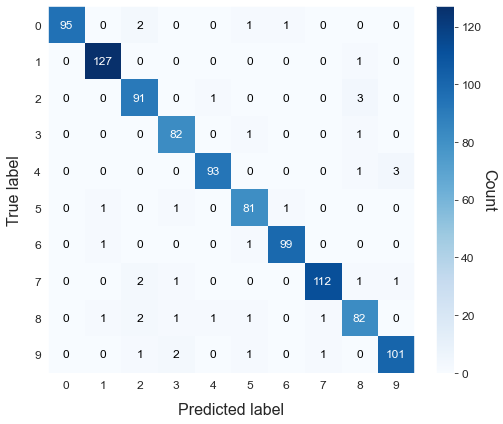

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()